# Example: Prospect Theory, adaptive robust control

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import scipy
import seaborn
from tqdm import tqdm
import yfinance as yf
from scipy.stats import norm
from optimization_functions import *
from functions_adaptive import *
%load_ext autoreload
%autoreload 2
%aimport optimization_functions
%aimport functions_adaptive
    

Download Stock Prices and create Training Periods

In [2]:
stocks = ["GOOGL","EBAY","AMZN","MSFT","AAPL"]
Returns_train_tf_dict = {}

In [3]:
for s in stocks:
    S_train = yf.download(s, start="2010-01-02", end="2020-02-01")
    S_train = S_train.dropna()
    S_train = S_train.reset_index()
    S_train = S_train[["Date","Close"]]
    
    Returns_train = S_train["Close"].diff() / S_train["Close"].shift(1)
    Returns_train = Returns_train.dropna()
    # A Tensorflow Adaption
    Returns_train_tf_dict[s] = tf.reshape(Returns_train,(1,len(Returns_train)))

N_returns = Returns_train_tf_dict[s].shape[1]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Computation of $\varepsilon_t$

Test Period 1: Feb 2020 - May 2020

# Description of the Algorithm

For $t = T-1, \cdots , 1$ :


For $j = 1,\dots, N_{iterations}$:

Sample $(\omega_1,\dots,\omega_t)=\omega^t$

Sample $(a_0,\dots,a_{t-1})=a^t$

For $k = 1,\dots, N_{measures}$:

Sample next states
$w^{t+1, (k),(i)} \sim \mathbb{P}_k \in \mathcal{P}_t(\omega^t)$ for $i= 1,\dots,N_{MC}$

<!-- Compute $\tilde{J}_t(\omega,a^t, \tilde{a}) = \min_k \frac{1}{N}\sum_{i=1} \tilde{\Psi}_{t+1}((\omega^t,a^t, \tilde{a}))$
Maximize w.r.t. $\widetilde{a}$:

$\widetilde{a}_t(\omega^t,a^t)=argmax_{\widetilde{a}} \tilde{J}_t(\omega,a^t, \tilde{a})$

Approximate

$\tilde{\Psi}_t(\omega^t, a^t):= \tilde{J}_t(\omega,a^t, \widetilde{a}_t(\omega^t,a^t))$ -->

The optimization step is:

1.)

Maximize
$$
\sup_{\widetilde{a} \in A}\inf_{ P \in \mathcal{P}_t(\omega^t)} E_P \left[\Psi_{t+1}\left(\omega^t \otimes_t \cdot, (a^{t},\widetilde{a})\right)\right]= \Psi_t(\omega^t,a^t)
$$
 w.r.t. parameters of $\tilde{a}_t$:

 Alternative:

 By using a dual approach we have in the special case of a Wasserstein distance
 $$
\Psi_t(\omega^t,a^t)=\sup_{\widetilde{a} \in A}\inf_{ P \in \mathcal{P}_t(\omega^t)} E_P \left[\Psi_{t+1}\left(\omega^t \otimes_t \cdot, (a^{t},\widetilde{a})\right)\right]
$$
$$
= \sup_{\widetilde{a} \in A}\sup_{ \lambda \geq 0} E_{\widehat{P}} \left[\inf_{z} \left\{\Psi_{t+1}\left(\omega^t \otimes_t z, (a^{t},\widetilde{a})\right)+\lambda \|\cdot -z\|\right\}\right] - \lambda \varepsilon_t
$$
$$
= \sup_{\widetilde{a} \in A}\sup_{ \lambda \geq 0} \frac{1}{N_{MC}} \sum_{i=1}^{N_{MC}} \left[\min_{j=1,\dots,N} \left\{\Psi_{t+1}\left(\omega^t \otimes_t z_j, (a^{t},\widetilde{a})\right)+\lambda \|x_i -z_j\|\right\}\right] - \lambda \varepsilon_t
$$
$$
= \sup_{\widetilde{a} \in A}\sup_{ \lambda \geq 0}  \sum_{i=t}^{N-1} \left[\frac{1}{N} \min_{j=1,\dots,N} \left\{\Psi_{t+1}\left(\omega^t \otimes_t z_j, (a^{t},\widetilde{a})\right)+\lambda \|\mathcal{R}_{i+1} -z_j\|\right\}\right] - \lambda \varepsilon_t
$$
with 
$$
\mathcal{P}_t(\omega^t) = \bigg\{ \mathbb{P}~|~d(\mathbb{P}, \widehat{\mathbb{P}}(\omega^t)) < \frac{H^\alpha}{\sqrt{N+t}} \bigg\}
$$
for $H^\alpha$ being the $\alpha$ quantile of $\int_0^1 |B(s)|d Q^*(s)$ for a Brownian bridge $B$ and a quantile function $Q^*$ of the true distribution of returns and with 
$$
\widehat{\mathbb{P}}(\omega^t) = \frac{1}{N+t} \left(\sum_{s=1}^N \delta_{\mathcal{R}_s} + \sum_{i=1}^{t} \delta_{\omega_i}\right)
$$

2.)


Minimize
$$
\sum_{b=1}^B \left(\tilde{\Psi}_t(\omega^t_b, a^t_b)- \left(\sup_{\widetilde{a} \in A}\sup_{ \lambda \geq 0}  \sum_{i=t}^{N-1} \left[\frac{1}{N}  \min_{j=1,\dots,N} \left\{\Psi_{t+1}\left(\omega^t \otimes_t z_j, (a^{t},\widetilde{a})\right)+\lambda \|\mathcal{R}_{i+1} -z_j\|\right\}\right] - \lambda \varepsilon_t \right)  \right)^2
$$
 w.r.t. parameters of $\tilde{\Psi}_t$:

Finally, we set:
$$
\Omega^t \ni \omega^t =(\omega_1,\dots,\omega_{t}) \mapsto a_t^*(\omega^t):= \widetilde{a}_t^*\left(\omega^t,~\left(a_0^*,\dots,a_{t-1}^*(\omega_1,\dots,\omega_{t-1}\right)\right) \in A.
$$

# Training

Number of periods

In [4]:
T = 10

Initialize the dictionaries

In [5]:
a_tilde_robust_adaptive_dict = {}

Set the parameters

In [6]:
# Number of iterations per epoch
inner_psi = 2000
inner_a = 500
# Tolerance levels to break the loop
tolerance_psi = 0.00001
tolerance_a = 0.000001
# Leraning rates
learning_rate_Psi = 0.001
learning_rate_a = 0.001
learning_rate_LAM = 0.001
# Number of Monte Carlo Simulations
N_MC = 128
N_MC_inner = 128
#Batch Sizes
Batch_size_a = 128
Batch_size_psi = 128

Compute the epsilons

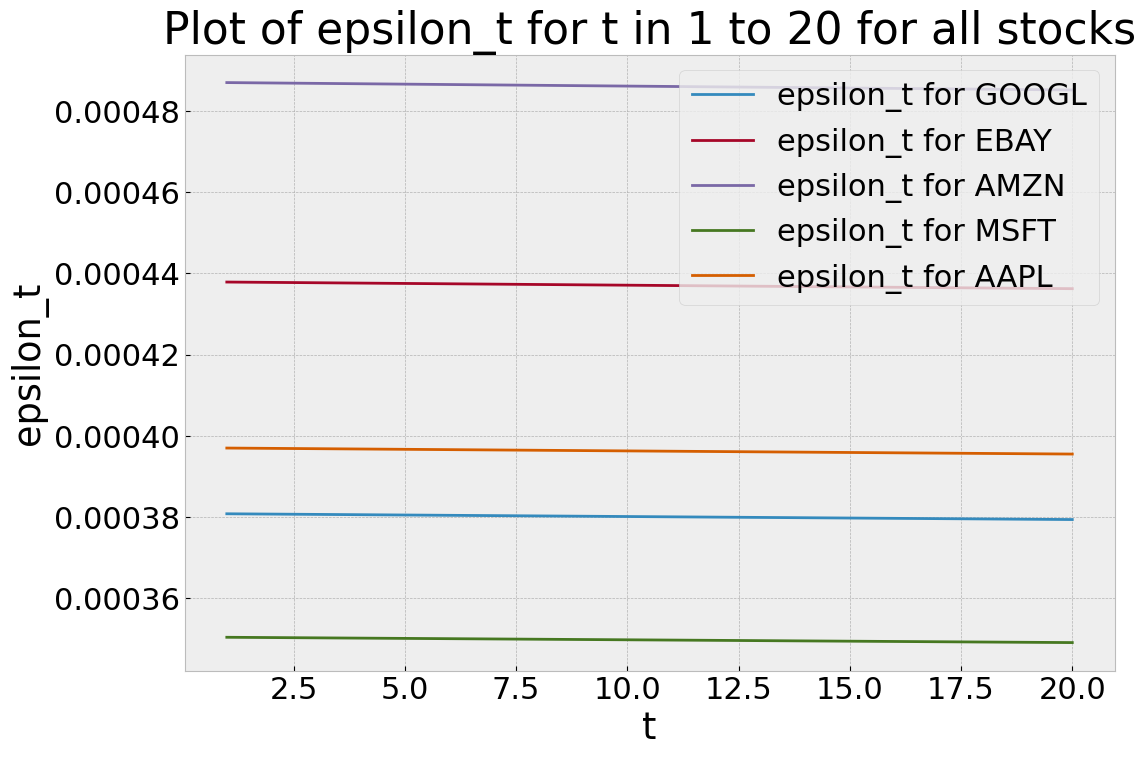

In [7]:
dict_H = {}
for s in stocks:
    dict_H[s] = H_alpha(Returns_train_tf_dict[s],N= 10000,alpha = 0.9)
    
import matplotlib.pyplot as plt
import numpy as np

t_values = np.arange(1, 21)  # t values from 1 to 20

# Plot
plt.figure(figsize=(12, 8))

for stock, H_alpha_values in dict_H.items():
    # Calculate H_alpha/(t+N) for t in 1 to 20
    results = [H_alpha_values/np.sqrt(t + N_returns) for t in t_values]
    
    # Plot the results
    plt.plot(t_values, results, label=f'epsilon_t for {stock}')

# Add labels and legend
plt.xlabel('t')
plt.ylabel("epsilon_t")
plt.title('Plot of epsilon_t for t in 1 to 20 for all stocks')
plt.legend()
plt.grid(True)
plt.show()

Train

In [9]:
for s in stocks:
    #compute
    print("Start optimization for Stock: {}".format(s))
    print("Robust, adaptive")
    a_tilde_robust_adaptive_dict[s], _ = train_networks_adaptive(Returns_train_tf_dict[s],T=T,inner_psi = inner_psi,
                       inner_a =inner_a, N_MC=N_MC, N_MC_inner=N_MC_inner,
                       H_alpha_const = dict_H[s],tolerance_psi =tolerance_psi,
                       tolerance_a = tolerance_a, learning_rate_Psi = learning_rate_Psi,learning_rate_a = learning_rate_a,
                                        learning_rate_LAM = learning_rate_LAM,
                                        Batch_size_a = Batch_size_a,
                                        Batch_size_psi = Batch_size_psi,print_intermediate_results = True)   
    #save
    file_save(a_tilde_robust_adaptive_dict[s],s,"Robust_adaptive")

Start optimization for Stock: GOOGL
Robust, adaptive
Start Backwards Iterations
#########
# t = 9 #
#########

a: -0.8821667432785034
a: -0.8837065696716309
a: -0.8969593644142151
a: -0.8670265674591064
a: -0.8894767761230469
a: -0.877189576625824
a: -0.8802692294120789
a: -0.8758640289306641
a: -0.8904639482498169
a: -0.8702722787857056
a: -0.8814003467559814
a: -0.8594878315925598
a: -0.8816181421279907
a: -0.8615100383758545
a: -0.8845563530921936
a: -0.8862876296043396
a: -0.8715285658836365
a: -0.8674001097679138
a: -0.8713828921318054
Psi: 0.44946202635765076
Psi: 0.15536528825759888
Psi: 0.048710934817790985
Psi: 0.021756742149591446
Psi: 0.013323587365448475
Psi: 0.01024239044636488
Psi: 0.008981128223240376
Psi: 0.007966136559844017
Psi: 0.0075124516151845455
Psi: 0.007543921936303377
Psi: 0.006545624695718288
Psi: 0.006518533919006586
Psi: 0.0058785998262465
Psi: 0.006178872659802437
Psi: 0.005964512936770916
Psi: 0.005406548269093037
Psi: 0.004870817996561527
Psi: 0.00499985